In [225]:
from setup import *
from agents import *

class Log:
    def __init__(self, gameData, buyerStrategies, sellerStrategies,disclosure):
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps = gameData
        self.stepData = pd.DataFrame(columns=['rnd', 'period', 'step', 'bids','asks','currentBid','currentBidIdx','currentAsk',
                                             'currentAskIdx','buy','sell','price','sale', 'bprofit', 'sprofit'])
        self.roundData = pd.DataFrame(columns=['rnd', 'redemptionValues', 'tokenCosts', 'demand', 'supply', 'prices', 'peq', 'qeq', 
                                              'buyerReservationPrices', 'sellerReservationPrices', 'buyerSurplus', 'sellerSurplus', 
                                              'totalSurplus', 'buyerSurplusFrac', 'sellerSurplusFrac'])
        self.disclosure = disclosure
        
    def addStep(self, stepData):
        self.stepData.loc[len(self.stepData.index)] = stepData

    def addRound(self, roundData):
        self.roundData.loc[len(self.roundData.index)] = roundData
    
    def disclose(self):
        return self.stepData[self.disclosure].iloc[-1]
        
    def getPeriod(self, rnd, period):
        return self.stepData[(self.stepData.rnd==rnd) & (self.stepData.period==period)]
        
    def getPeriodActivity(self, rnd, period):
        periodData = self.getPeriod(rnd, period)
        periodBids = list(periodData.bids)
        periodAsks = list(periodData.asks)
        periodPrices = list(periodData.price)
        periodSales = np.cumsum(np.where(periodData.price > 0,1,0))
        return periodBids, periodAsks, periodPrices, periodSales

    def getRound(self, rnd):
        return self.roundData[(self.roundData.rnd==rnd)]

    def getRoundList(self, rnd):
        return self.getRound(rnd).values.tolist()[0][1:]


In [226]:
class BaseEnv:
    def __init__(self, metaData):
        self.gameData = metaData[0:7]
        self.gameTypes, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps = self.gameData
        self.disclosure, self.buyerStrategies, self.sellerStrategies = metaData[7:]
        self.buyers, self.sellers = generateAgents(self.gameData,self.buyerStrategies,self.sellerStrategies,self.disclosure)
        self.log = Log(self.gameData, self.buyerStrategies, self.sellerStrategies, self.disclosure)

    def simulate(self):
        for rnd in range(self.numRounds):
            roundData = roundSetup(*self.gameData)
            redemptionValues, tokenCosts, demand, supply, prices, peq, qeq  = roundData[0:7]
            [buyerReservationPrices, sellerReservationPrices, buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac] = roundData[7:]
            self.log.addRound([rnd] + roundData)
            resetRounds(self.buyers, self.sellers, redemptionValues, tokenCosts)
            for period in range(self.numPeriods):
                resetPeriods(self.buyers, self.sellers)
                for step in range(self.numSteps):
                    resetSteps(self.buyers, self.sellers)
                    bids, asks = collectOffers(self.buyers, self.sellers)
                    currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
                    price, buy, sell = trade(self.buyers, self.sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)
                    bprofit, sprofit = 0, 0
                    if price > 0:
                        self.buyers[currentBidIdx].transact(price)
                        self.sellers[currentAskIdx].transact(price)
                        bprofit = self.buyers[currentBidIdx].stepProfits
                        sprofit = self.sellers[currentAskIdx].stepProfits
                    self.log.addStep([rnd, period, step, bids, asks, currentBid, currentBidIdx, currentAsk, currentAskIdx, buy, sell, price, price>0, bprofit, sprofit])
                    observe(self.buyers, self.sellers, self.log.disclose())

    def graphSales(self, rnd, period):
        fig, ax = graphMarket(*self.gameData, *self.log.getRoundList(rnd))
        periodBids, periodAsks, periodPrices, periodSales = self.log.getPeriodActivity(rnd,period)
        plt.plot(range(1,len(periodPrices)+1), periodPrices, color='darkgreen', linestyle='--', label='Actual Prices')
        plt.plot([periodSales[i] for i in range(self.numSteps) if periodPrices[i] > 0],[periodBids[i][0] for i in range(self.numSteps) if periodPrices[i] > 0], color='darkorange', linestyle='--', label='Reinforcer Bids')
        for i in range(self.numSteps):
            if (periodPrices[i] > 0):
                ax.scatter(np.array([periodSales[i]] * len(periodBids[i][1:])), np.array(periodBids[i][1:]), s=10, alpha=0.5, c='purple')
                ax.scatter([periodSales[i]] * len(periodAsks[i]), periodAsks[i], s=10, alpha=0.5, c='blue')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
        plt.show()


    def graphOffers(self, rnd, period):
        periodBids, periodAsks, periodPrices, periodSales = self.log.getPeriodActivity(rnd,period)
        fig, ax = plt.subplots()
        ax.plot(periodBids, c='purple', linestyle='--', label='Bids')
        ax.plot(periodAsks, c='darkgreen', linestyle='--', label='Asks')
        ax.scatter(range(self.numSteps), periodPrices, c='black', label='Prices')
        ax.set_title('Bids (red), Asks (blue), and Prices (green) over trading steps')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
        plt.show()

In [227]:
# from env import *
gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps = '1000', 4, 4, 4, 1, 1, 16
disclosure = ['rnd', 'period', 'step','currentBid','currentAsk','buy','sell','price','sale']
buyerStrategies = ['TruthTeller', 'TruthTeller', 'TruthTeller']
sellerStrategies = ['TruthTeller', 'TruthTeller', 'TruthTeller']
metaData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, disclosure, buyerStrategies, sellerStrategies]
env = BaseEnv(metaData)
env.simulate()

In [228]:
env.log.roundData.redemptionValues.item()

array([[100. ,  90.3,  21.5,  11. ],
       [ 57.2,  47.8,  45.5,  30.5],
       [ 90. ,  36.9,  30.4,  23.7],
       [ 88.2,  57. ,  46.3,  22.7]])

In [229]:
env.log.roundData.tokenCosts.item()

array([[ 0.5, 23.7, 47. , 83.4],
       [ 0.2, 22.5, 23.4, 38.2],
       [ 0. , 24.5, 46.8, 81.4],
       [12. , 29. , 48.6, 61.9]])

In [230]:
env.log.stepData

,rnd,period,step,bids,asks,currentBid,currentBidIdx,currentAsk,currentAskIdx,buy,sell,price,sale,bprofit,sprofit
0,0,0,0,"[100.0, 57.2, 90.0]","[0.5, 0.2, 0.0]",100.0,0,0.0,2,True,True,50.00,True,50.00,50.00
1,0,0,1,"[90.3, 57.2, 90.0]","[0.5, 0.2, 24.5]",90.3,0,0.2,1,True,True,45.25,True,45.05,45.05
2,0,0,2,"[21.5, 57.2, 90.0]","[0.5, 22.5, 24.5]",90.0,2,0.5,0,True,True,45.25,True,44.75,44.75
3,0,0,3,"[21.5, 57.2, 36.9]","[23.7, 22.5, 24.5]",57.2,1,22.5,1,True,True,39.85,True,17.35,17.35
4,0,0,4,"[21.5, 47.8, 36.9]","[23.7, 23.4, 24.5]",47.8,1,23.4,1,True,True,35.60,True,12.20,12.20
5,0,0,5,"[21.5, 45.5, 36.9]","[23.7, 38.2, 24.5]",45.5,1,23.7,0,True,True,34.60,True,10.90,10.90
6,0,0,6,"[21.5, 30.5, 36.9]","[47.0, 38.2, 24.5]",36.9,2,24.5,2,True,True,30.70,True,6.20,6.20
7,0,0,7,"[21.5, 30.5, 30.4]","[47.0, 38.2, 46.8]",30.5,1,38.2,1,False,False,NaN,False,0.00,0.00
8,0,0,8,"[21.5, 30.5, 30.4]","[47.0, 38.2, 46.8]",30.5,1,38.2,1,False,False,NaN,False,0.00,0.00
9,0,0,9,"[21.5, 30.5, 30.4]","[47.0, 38.2, 46.8]",30.5,1,38.2,1,False,False,NaN,False,0.00,0.00


In [231]:
env.buyers[0].df

,rnd,period,step,currentBid,currentAsk,buy,sell,price,sale
0,0,0,0,100.0,0.0,True,True,50.0,True
1,0,0,1,90.3,0.2,True,True,45.25,True
2,0,0,2,90.0,0.5,True,True,45.25,True
3,0,0,3,57.2,22.5,True,True,39.85,True
4,0,0,4,47.8,23.4,True,True,35.6,True
5,0,0,5,45.5,23.7,True,True,34.6,True
6,0,0,6,36.9,24.5,True,True,30.7,True
7,0,0,7,30.5,38.2,False,False,NaN,False
8,0,0,8,30.5,38.2,False,False,NaN,False
9,0,0,9,30.5,38.2,False,False,NaN,False


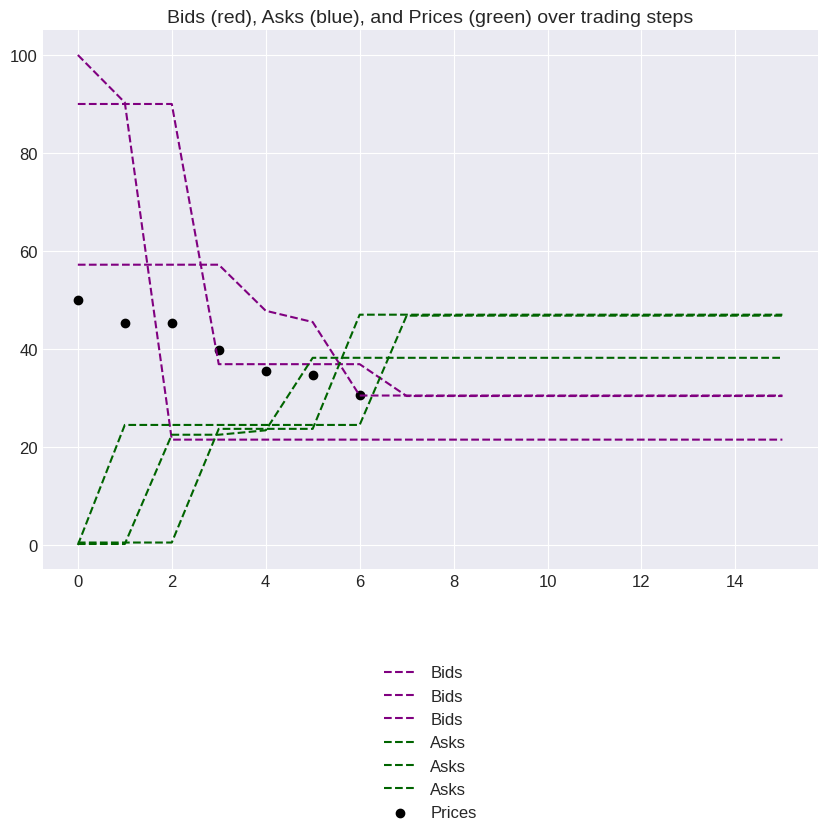

In [232]:
env.graphOffers(0,0)

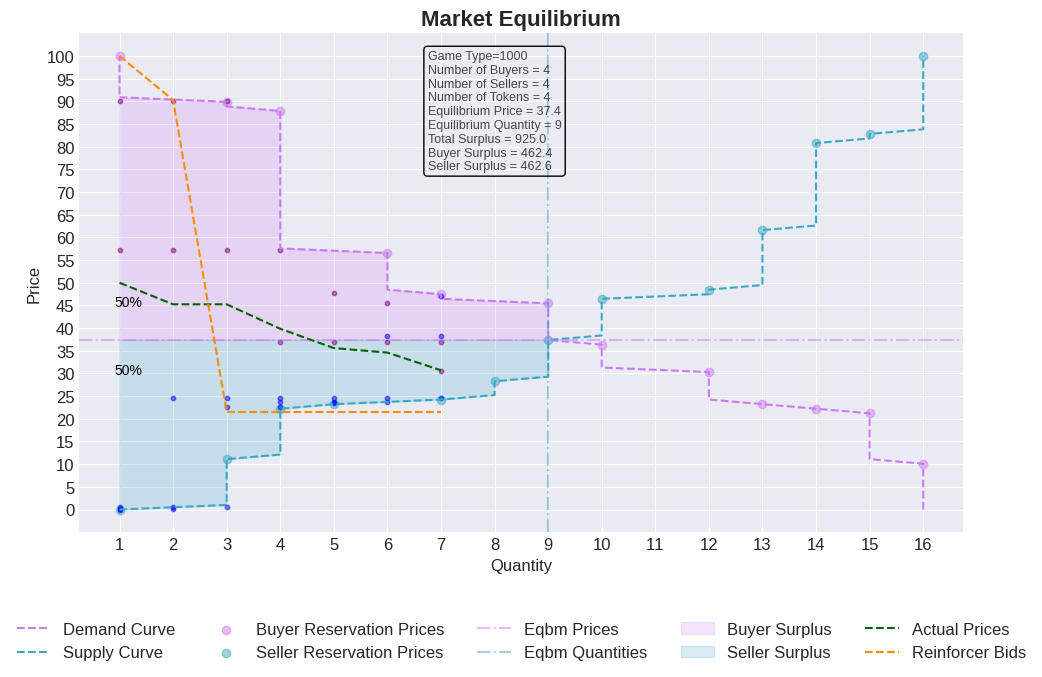

In [233]:
env.graphSales(0,0)